# Introduction to DEA Coastlines <img align="right" src="https://github.com/GeoscienceAustralia/dea-notebooks/raw/develop/Supplementary_data/dea_logo.jpg">

* [**Sign up to the DEA Sandbox**](https://docs.dea.ga.gov.au/setup/sandbox.html) to run this notebook interactively from a browser
* **Compatability:** Notebook currently compatible with both the `NCI` and `DEA Sandbox` environments
* **Products used:** [DEA Coastlines](https://cmi.ga.gov.au/data-products/dea/581/dea-coastlines)

## Background
Australia has a highly dynamic coastline of over 30,000 km, with over 85% of its population living within 50 km of the coast. 
This coastline is subject to a wide range of pressures, including extreme weather and climate, sea level rise and human development. 
Understanding how the coastline responds to these pressures is crucial to managing this region, from social, environmental and economic perspectives. 

### What this product offers
[Digital Earth Australia Coastlines](https://maps.dea.ga.gov.au/#share=s-DEACoastlines&playStory=1) is a continental dataset that includes annual shorelines and rates of coastal change along the entire Australian coastline from 1988 to the present. 

The product combines satellite data from Geoscience Australia's Digital Earth Australia program with tidal modelling to map the typical location of the coastline at mean sea level for each year. 
The product enables trends of coastal erosion and growth to be examined annually at both a local and continental scale, and for patterns of coastal change to be mapped historically and updated regularly as data continues to be acquired. 
This allows current rates of coastal change to be compared with that observed in previous years or decades. 

The ability to map shoreline positions for each year provides valuable insights into whether changes to our coastline are the result of particular events or actions, or a process of more gradual change over time. 
This information can enable scientists, managers and policy makers to assess impacts from the range of drivers impacting our coastlines and potentially assist planning and forecasting for future scenarios. 

### Applications
* Monitoring and mapping rates of coastal erosion along the Australian coastline 
* Prioritise and evaluate the impacts of local and regional coastal management based on historical coastline change 
* Modelling how coastlines respond to drivers of change, including extreme weather events, sea level rise or human development 
* Supporting geomorphological studies of how and why coastlines have changed across time 

### Publications
* Bishop-Taylor, R., Sagar, S., Lymburner, L., Alam, I., & Sixsmith, J. (2019). Sub-pixel waterline extraction: Characterising accuracy and sensitivity to indices and spectra. *Remote Sensing*, 11(24), 2984. Available: https://www.mdpi.com/2072-4292/11/24/2984

> **Note:** For more technical information about the DEA Coastlines product, visit the official Geoscience Australia [DEA Coastlines product description](https://cmi.ga.gov.au/data-products/dea/581/dea-coastlines).

## Description

This notebook will demonstrate how to load data from the [Digital Earth Australia Coastlines](https://cmi.ga.gov.au/data-products/dea/581/dea-coastlines) product using the Digital Earth Australia datacube. 
Topics covered include:

1. Loading DEA Coastlines data in a Jupyter notebook or Python using the DEA Coastlines Web Feature Service (WFS)
2. Interactively drawing a transect across DEA Coastlines annual coastlines and generating a plot of coastal change through time
3. Interactively plotting the distribution of retreating and growing coastlines within a selected region

***


## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell.

### Load packages

In [1]:
import sys
import geopandas as gpd
import matplotlib.pyplot as plt

sys.path.append('../Scripts')
from dea_coastaltools import deacoastlines_transect
from dea_coastaltools import deacoastlines_histogram


## Loading DEA Coastlines data using Web Feature Service (WFS)

DEA Coastlines data can be loaded directly in a Python script or Jupyter Notebook using the DEA Coastlines Web Feature Service (WFS) and `geopandas`:


In [2]:
# Specify bounding box
ymax, xmin = -33.65, 115.28
ymin, xmax = -33.66, 115.30

# Set up WFS requests for annual coastlines & rates of change statistics
deacl_coastlines_wfs = f'https://geoserver.dea.ga.gov.au/geoserver/wfs?' \
                       f'service=WFS&version=1.1.0&request=GetFeature' \
                       f'&typeName=dea:coastlines&maxFeatures=1000' \
                       f'&bbox={ymin},{xmin},{ymax},{xmax},' \
                       f'urn:ogc:def:crs:EPSG:4326'
deacl_statistics_wfs = f'https://geoserver.dea.ga.gov.au/geoserver/wfs?' \
                       f'service=WFS&version=1.1.0&request=GetFeature' \
                       f'&typeName=dea:coastlines_statistics&maxFeatures=1000' \
                       f'&bbox={ymin},{xmin},{ymax},{xmax},' \
                       f'urn:ogc:def:crs:EPSG:4326'

# Load DEA Coastlines data from WFS using geopandas
deacl_coastlines_gdf = gpd.read_file(deacl_coastlines_wfs)
deacl_statistics_gdf = gpd.read_file(deacl_statistics_wfs)

# Ensure CRSs are set correctly
deacl_coastlines_gdf.crs = 'EPSG:3577'
deacl_statistics_gdf.crs = 'EPSG:3577'

# Print example output
deacl_coastlines_gdf.head()

,gml_id,year,certainty,geometry
0,coastlines.633,1988,good,"MULTILINESTRING ((-1515201.261 -3750001.375, -..."
1,coastlines.634,1989,good,"MULTILINESTRING ((-1515192.442 -3750001.375, -..."
2,coastlines.635,1990,good,"MULTILINESTRING ((-1515201.862 -3750001.375, -..."
3,coastlines.636,1991,good,"MULTILINESTRING ((-1515211.079 -3750001.375, -..."
4,coastlines.637,1992,good,"MULTILINESTRING ((-1515205.461 -3750001.375, -..."


We can now analyse and plot the loaded data like any other `geopandas` object:

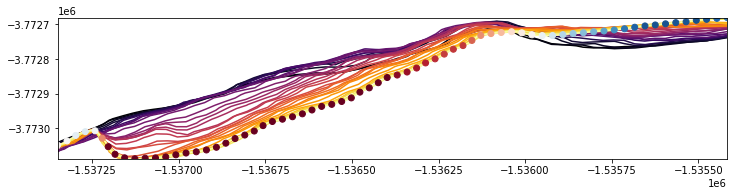

In [3]:
# Set up figure
fig, ax = plt.subplots(1, 1, figsize=(12, 5))

# Set plot limits to extent of statistics points
bounds = deacl_statistics_gdf.geometry.total_bounds
ax.set_xlim(bounds[[0, 2]])
ax.set_ylim(bounds[[1, 3]])

# Plot data
deacl_statistics_gdf.plot(ax=ax,
                          column='rate_time',
                          cmap='RdBu',
                          vmin=-2.5,
                          vmax=2.5)
deacl_coastlines_gdf.plot(ax=ax, column='year', cmap='inferno', zorder=0)

## DEA Coastlines analysis tools

The following sections provide useful tools for analysing DEA Coastlines data directly within a Jupyter Notebook without needing to load the data into a GIS.
All outputs from the tools below will be saved to a new folder in this directory called `deacoastlines_outputs`.

### Interactive profile selection
This tool allows you to interactively draw a transect over DEA Coastlines annual shoreline data, and get back a table and graph showing how shoreline positions have changed over time.
To use the tool:

1. Run the cell below; an interactive map will appear 
2. Zoom in and use the `Draw a polyline` tool on the left to draw a transect across a set of coastlines
3. Press `Finish` when you are happy with the line, then click `Done` in the top right
4. A graph will appear below the map showing distances along the transect to each annual coastline (distances will be measured from the start of the transect line you drew above)

> **Optional:** Set `transect_mode='width'` and re-run the cell below to measure the width between two adjacent sets of coastlines (e.g. across the next of a tombolo or sandbar)

> **Optional:** By default, this tool will export a set of output datasets and figures into a new folder in this directory called `deacoastlines_outputs` unless the `export_*` parameters below are set to `False`. These outputs include:
> * `export_transect_data`: A CSV file containing the data (i.e. years and distances) extracted for the transect
> * `export_transect`: Vector files in ESRI Shapefile and GeoJSON format for the transect line feature
> * `export_figure`: A PNG image file for the transect figure generated by the tool

Map(center=[-26, 135], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

Loading DEA Coastlines data...

Exporting transect data to:
    deacoastlines_outputs/deacoastlines_transect_131.870_-12.221.csv

Exporting transect vectors to:
    deacoastlines_outputs/deacoastlines_transect_131.870_-12.221.shp
    deacoastlines_outputs/deacoastlines_transect_131.870_-12.221.geojson

Exporting transect figure to:
    deacoastlines_outputs/deacoastlines_transect_131.870_-12.221.png



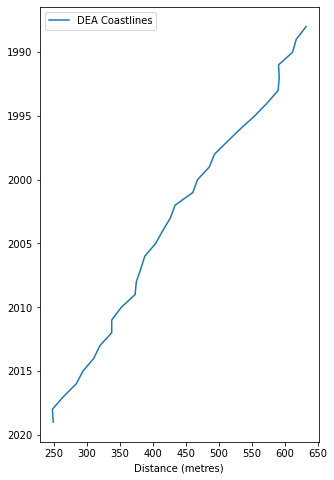

In [4]:
df = deacoastlines_transect(transect_mode='distance',
                            export_transect_data=True,
                            export_transect=True,
                            export_figure=True)


### Statistics point histogram analysis
This tool allows you to draw a polygon or rectangle around DEA Coastlines rates of change statistics points, and get back a histogram showing the distribution of growing or retreating points.
To use the tool:

1. Run the cell below; an interactive map will appear 
2. Use the `Draw a polygon` or `Draw a rectangle` tools on the left to select a region.
3. Press `Done` in the top right when ready
4. A histogram plot will appear below the map

> **Optional:** Instead of using the interactive map, supply a path to a vector file using the `extent_path` parameter (e.g. `extent_path='study_area.shp`). 
If this option is selected, you can also supply a column name in the dataset to `extent_id_col` which will be used to name the output files (e.g. `extent_id_col='compartment_id'`).
To revert to the interactive map, set `extent_path=None`.

> **Optional:** Set `hist_log=True` and re-run the cell below to generate a log-scale histogram plot

> **Optional:** By default, this tool will export a set of output datasets and figures into a new folder in this directory called `deacoastlines_outputs` unless the `export_*` parameters below are set to `False`. These outputs include:
> * `export_points_data`: A CSV file containing raw data for all DEA Coastlines rates of change statistics points in the selected extent
> * `export_summary_data`: A CSV file containing summary statistics for all rates of change statistics points in the selected extent
> * `export_extent`: Vector files in ESRI Shapefile and GeoJSON format giving the selected area extent
> * `export_figure`: A PNG image file for the histogram figure generated by the tool
   




Map(center=[-26, 135], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

Loading DEA Coastlines data for 131.825_-12.242...
    Plotting data with log axis after setting non-significant points to 0 m / year

Exporting extent vectors to:
    deacoastlines_outputs/deacoastlines_polygon_131.825_-12.242.shp
    deacoastlines_outputs/deacoastlines_polygon_131.825_-12.242.geojson

Exporting histogram figure to:
    deacoastlines_outputs/deacoastlines_polygon_131.825_-12.242.png

Exporting points data to:
    deacoastlines_outputs/deacoastlines_polygon_131.825_-12.242.csv

Exporting summary data to:
    deacoastlines_outputs/deacoastlines_polygon_summary.csv



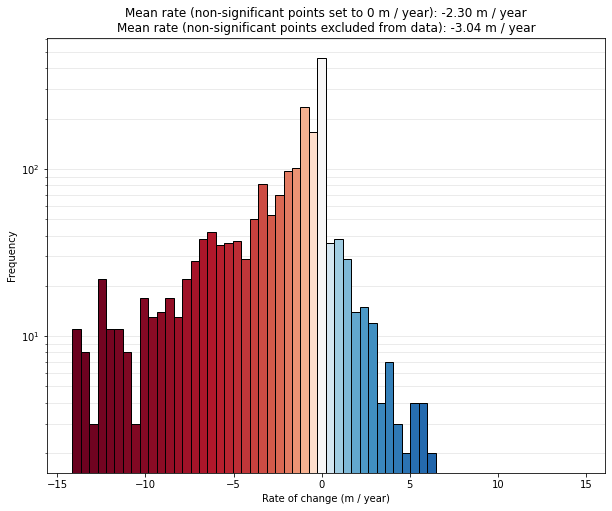

In [5]:
df = deacoastlines_histogram(extent_path=None,
                             extent_id_col=None,
                             hist_log=True,
                             export_points_data=True,
                             export_summary_data=True,
                             export_extent=True,
                             export_figure=True)

### Remove output files
Run this cell to clean up your directory by removing any output files generated by this notebook and saved to the `deacoastlines_outputs` folder. 

> **Note:** This cannot be undone, so ensure any important outputs have been downloaded to your computor before proceeding.


In [6]:
!rm -r deacoastlines_outputs

## Next steps: coastline erosion notebook

The [Coastal erosion notebook](../Real_world_examples/Coastal_erosion.ipynb) in this repository provides a simplified example of the method used to extract DEA Coastlines annual coastlines data. 
Run this notebook if you would like to generate more customised coastlines for a specific location, time period, epoch (e.g. annual or biennial coastlines) or tidal range (e.g. the posituion of the coastline at low, mid  or high tide).

> **Note:** This notebook currently supports extracting coastline data only, not generating rates of change statistics like those included in the DEA Coastlines product.

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** September 2020

## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)